In [97]:
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler

class SyntheticSKUDataGenerator:
    def __init__(self, num_skus, num_weeks, price_range, demand_range, price_noise=20, demand_noise=25):
        """
        Initializes the synthetic data generator.

        :param num_skus: Number of SKUs to generate data for.
        :param num_weeks: Number of weeks to generate data for.
        :param price_range: Tuple indicating the minimum and maximum price (min_price, max_price).
        :param demand_range: Tuple indicating the minimum and maximum demand (min_demand, max_demand).
        """
        self.num_skus = num_skus
        self.num_weeks = num_weeks
        self.price_range = price_range
        self.demand_range = demand_range
        self.price_noise = price_noise
        self.demand_noise = demand_noise

    def generate_data(self):
        """
        Generates synthetic data for SKUs.

        :return: A pandas DataFrame containing SKU, Week, Price, and Demand.
        """
        data = []
        for sku in range(1, self.num_skus + 1):
            for week in range(1, self.num_weeks + 1):
                # Generate price within the specified range with noise
                base_price = np.random.uniform(self.price_range[0], self.price_range[1])
                noise = np.random.uniform(-self.price_noise, self.price_noise)
                price = round(base_price + noise, 2)

                # Ensure price is within the defined range after adding noise
                price = max(self.price_range[0], min(price, self.price_range[1]))

                # Generate demand with a negative relationship to price and add noise
                demand = max(0, int(self.demand_range[0] + 
                                     (self.demand_range[1] - self.demand_range[0]) * 
                                     (1 - (base_price - self.price_range[0]) / (self.price_range[1] - self.price_range[0]))))

                # Add noise to demand
                demand_noise = np.random.randint(-self.demand_noise, self.demand_noise + 1)
                demand += demand_noise
                demand = max(0, demand)  # Ensure demand is not negative

                data.append({
                    'SKU': sku,
                    'Week': week,
                    'Price': price,
                    'Demand': demand
                })

        return pd.DataFrame(data)
# Usage
generator = SyntheticSKUDataGenerator(num_skus=1, num_weeks=100, price_range=(100, 250), demand_range=(50, 200))
sku_data = generator.generate_data()
# Display a sample of the generated data
print(sku_data.head())
sku_data["log_price"], sku_data["log_demand"] = np.log(sku_data["Price"]),  np.log(sku_data["Demand"])

   SKU  Week   Price  Demand
0    1     1  208.63     133
1    1     2  232.60      44
2    1     3  111.02     208
3    1     4  138.60     182
4    1     5  238.15      73


In [98]:
from tabulate import tabulate
print(tabulate(sku_data.head(), headers='keys', tablefmt='psql'))

+----+-------+--------+---------+----------+-------------+--------------+
|    |   SKU |   Week |   Price |   Demand |   log_price |   log_demand |
|----+-------+--------+---------+----------+-------------+--------------|
|  0 |     1 |      1 |  208.63 |      133 |     5.34056 |      4.89035 |
|  1 |     1 |      2 |  232.6  |       44 |     5.44932 |      3.78419 |
|  2 |     1 |      3 |  111.02 |      208 |     4.70971 |      5.33754 |
|  3 |     1 |      4 |  138.6  |      182 |     4.93159 |      5.20401 |
|  4 |     1 |      5 |  238.15 |       73 |     5.4729  |      4.29046 |
+----+-------+--------+---------+----------+-------------+--------------+


### EDA

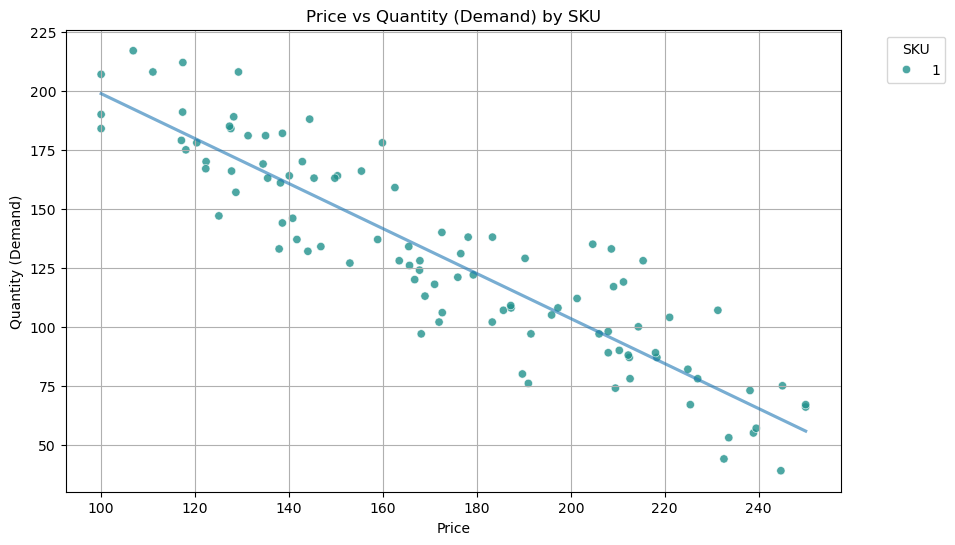

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sku_data, x="Price", y="Demand", hue="SKU", palette="viridis", alpha=0.8)
for sku in sku_data["SKU"].unique():
    subset = sku_data[sku_data["SKU"] == sku]
    sns.regplot(
        data=subset, x="Price", y="Demand", 
        scatter=False, ci=None, line_kws={"alpha": 0.6}  # Trendline for each SKU
    )
plt.title("Price vs Quantity (Demand) by SKU")
plt.xlabel("Price")
plt.ylabel("Quantity (Demand)")
plt.legend(title="SKU", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

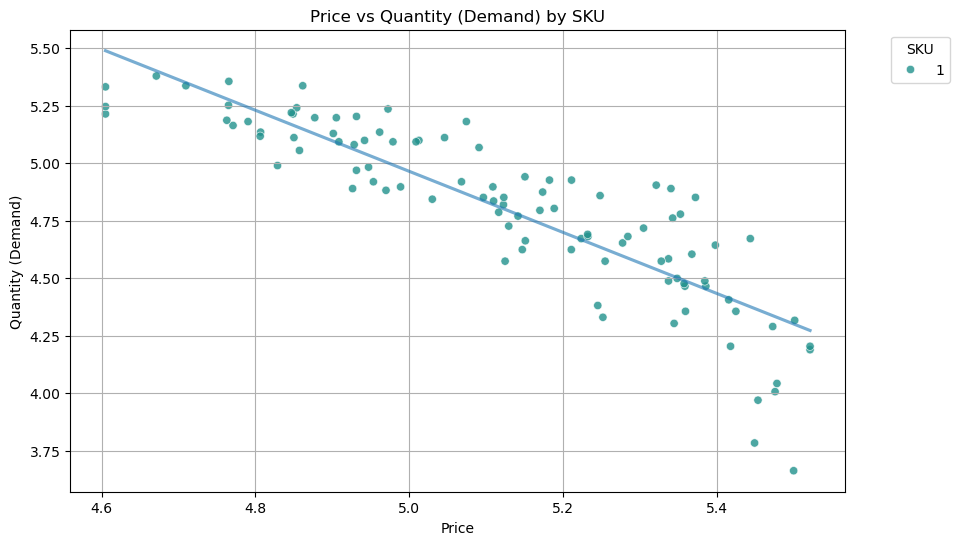

In [100]:
# Plot: Price vs Quantity (Demand)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sku_data, x="log_price", y="log_demand", hue="SKU", palette="viridis", alpha=0.8)
for sku in sku_data["SKU"].unique():
    subset = sku_data[sku_data["SKU"] == sku]
    sns.regplot(
        data=subset, x="log_price", y="log_demand", 
        scatter=False, ci=None, line_kws={"alpha": 0.6}  # Trendline for each SKU
    )
plt.title("Price vs Quantity (Demand) by SKU")
plt.xlabel("Price")
plt.ylabel("Quantity (Demand)")
plt.legend(title="SKU", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

### OLS regression

In [101]:
import statsmodels.api as sm
# Add a constant for the intercept term
X = sm.add_constant(sku_data["log_price"])  # Independent variable (Price)
y = sku_data["log_demand"]  # Dependent variable (Demand)

# Run OLS regression (Ordinary Least Squares)
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             log_demand   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     315.2
Date:                Fri, 25 Oct 2024   Prob (F-statistic):           2.20e-32
Time:                        10:01:33   Log-Likelihood:                 30.359
No. Observations:                 100   AIC:                            -56.72
Df Residuals:                      98   BIC:                            -51.51
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.6034      0.384     30.254      0.0

In [102]:
sku_data["pred_ols"] = model.params[0] + model.params[1] * sku_data["log_price"]

C:\Users\feder\AppData\Local\Temp\ipykernel_9520\1596646548.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sku_data["pred_ols"] = model.params[0] + model.params[1] * sku_data["log_price"]


### PYMC Model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
Sampling: [y_obs]


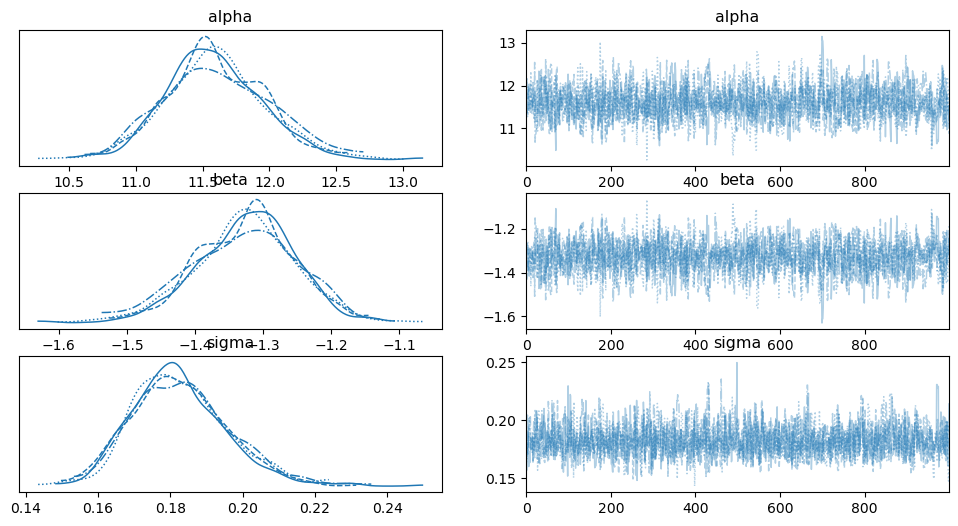

         mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha  11.598  0.380    10.877     12.338      0.011    0.008    1212.0   
beta   -1.327  0.074    -1.474     -1.187      0.002    0.002    1219.0   
sigma   0.183  0.013     0.159      0.209      0.000    0.000    1867.0   

       ess_tail  r_hat  
alpha    1420.0   1.01  
beta     1487.0   1.01  
sigma    1559.0   1.00  


In [103]:
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

# Prepare the data for PyMC3
log_price = sku_data["log_price"].values
log_demand = sku_data["log_demand"].values

# Bayesian log-log model specification
with pm.Model() as log_log_model:
    # Priors for the intercept (alpha) and slope (beta - price elasticity)
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=-1.5, sigma=0.5)  # Price elasticity

    # Likelihood: Log demand as a linear function of log price
    mu = alpha + beta * log_price
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Observed data
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=log_demand)

    # Sampling from the posterior
    trace = pm.sample(1000, return_inferencedata=True)

    posterior_predictive = pm.sample_posterior_predictive(trace)

# Plot the trace for alpha and beta
az.plot_trace(trace)
plt.show()

# Summary of posterior estimates
print(az.summary(trace, hdi_prob=0.95))


In [104]:
alpha_posterior = trace.posterior['alpha'].mean(axis=(0,1))
beta_posterior = trace.posterior['beta'].mean(axis=(0,1))
sku_data['a_bayesian'] = alpha_posterior.values
sku_data["b_bayesian"] = beta_posterior.values
sku_data["pred_bayesian"] = sku_data["a_bayesian"] + sku_data["b_bayesian"] * sku_data["log_price"]
sku_data

,SKU,Week,Price,Demand,log_price,log_demand,pred_ols,a_bayesian,b_bayesian,pred_bayesian
0,1,1,208.63,133,5.340562,4.890349,4.513497,11.597856,-1.326626,4.512925
1,1,2,232.60,44,5.449320,3.784190,4.369115,11.597856,-1.326626,4.368644
2,1,3,111.02,208,4.709710,5.337538,5.350985,11.597856,-1.326626,5.349830
3,1,4,138.60,182,4.931592,5.204007,5.056426,11.597856,-1.326626,5.055476
4,1,5,238.15,73,5.472901,4.290459,4.337811,11.597856,-1.326626,4.337362
...,...,...,...,...,...,...,...,...,...,...
95,1,96,245.06,75,5.501503,4.317488,4.299840,11.597856,-1.326626,4.299417
96,1,97,138.59,144,4.931520,4.969813,5.056521,11.597856,-1.326626,5.055572
97,1,98,187.21,109,5.232231,4.691348,4.657312,11.597856,-1.326626,4.656640
98,1,99,127.34,185,4.846861,5.220356,5.168911,11.597856,-1.326626,5.167883


### R2s

In [105]:
from sklearn.metrics import r2_score
sku_data["r2_ols"] = r2_score(sku_data["log_demand"], sku_data["pred_ols"])
sku_data["r2_bayesian"] = r2_score(sku_data["log_demand"], sku_data["pred_bayesian"])
sku_data

,SKU,Week,Price,Demand,log_price,log_demand,pred_ols,a_bayesian,b_bayesian,pred_bayesian,r2_ols,r2_bayesian
0,1,1,208.63,133,5.340562,4.890349,4.513497,11.597856,-1.326626,4.512925,0.762799,0.762794
1,1,2,232.60,44,5.449320,3.784190,4.369115,11.597856,-1.326626,4.368644,0.762799,0.762794
2,1,3,111.02,208,4.709710,5.337538,5.350985,11.597856,-1.326626,5.349830,0.762799,0.762794
3,1,4,138.60,182,4.931592,5.204007,5.056426,11.597856,-1.326626,5.055476,0.762799,0.762794
4,1,5,238.15,73,5.472901,4.290459,4.337811,11.597856,-1.326626,4.337362,0.762799,0.762794
...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,96,245.06,75,5.501503,4.317488,4.299840,11.597856,-1.326626,4.299417,0.762799,0.762794
96,1,97,138.59,144,4.931520,4.969813,5.056521,11.597856,-1.326626,5.055572,0.762799,0.762794
97,1,98,187.21,109,5.232231,4.691348,4.657312,11.597856,-1.326626,4.656640,0.762799,0.762794
98,1,99,127.34,185,4.846861,5.220356,5.168911,11.597856,-1.326626,5.167883,0.762799,0.762794
